In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
from google.colab import files

In [19]:
fear_files = pd.read_csv('fear_greed_index.csv')
hist_files = pd.read_csv('historical_data.csv')

In [20]:
fear_files.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [21]:
hist_files.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [22]:
def parse_dt(series):
  s = pd.to_datetime(series, errors='coerce', infer_datetime_format=True)
  if s.isna().all():
    try:
      s2 = pd.to_datetime(pd.to_numeric(series, errors='coerce'),units='ms', errors='coerce')
      if not s2.isna().all():
        return s2
    except Exception:
      pass
  return s

In [23]:
def savefig(fname, dpi=150):
  plt.tight_layout()
  plt.savefig(fname, dpi=dpi)
  print("Saved figure: ",fname)

In [24]:
fear = pd.read_csv('fear_greed_index.csv', low_memory=False)
hist = pd.read_csv('historical_data.csv', low_memory=False)
print("Fear Column: ",fear.columns.tolist())
print("Hist Column: ",hist.columns.tolist())

Fear Column:  ['timestamp', 'value', 'classification', 'date']
Hist Column:  ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


In [25]:
date_candidates = ['date', 'timestamp']
for col in date_candidates:
    if col in fear.columns:
        fear['date_parsed'] = parse_dt(fear[col])
        break
else:
    fear['date_parsed'] = parse_dt(fear.iloc[:, 0])
value_candidates = ['value', 'index', 'fear_greed_index', 'fear & greed index', 'fear_greed']
value_col = next((c for c in fear.columns if c.lower() in value_candidates), None)

if value_col is None:
    numeric_cols = [c for c in fear.columns if pd.api.types.is_numeric_dtype(fear[c])]
    value_col = numeric_cols[0] if numeric_cols else None
if value_col:
    fear['sentiment_raw'] = pd.to_numeric(fear[value_col], errors='coerce')
else:
    fear['sentiment_raw'] = 50.0
fear = (fear[['date_parsed', 'sentiment_raw']]
        .rename(columns={'date_parsed': 'date'})
        .dropna(subset=['date'])
        .sort_values('date')
        .drop_duplicates('date')
        .set_index('date'))
fear['sentiment_label'] = np.where(fear['sentiment_raw'] <= 50, 'fear', 'greed')
print("Fear index time range:", fear.index.min(), "to", fear.index.max())

Fear index time range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00


In [28]:
hist_col_lower = [c.lower() for c in hist.columns]
timestamp_candidates = ['timestamp ist', 'timestamp', 'time', 'date', 'datetime']
timestamp_col = None
for candidate in timestamp_candidates:
    if candidate in hist_col_lower:
        timestamp_col = hist.columns[hist_col_lower.index(candidate)]
        break
if timestamp_col is None:
    timestamp_col = hist.columns[0]
hist['date_parsed'] = parse_dt(hist[timestamp_col])
def find_column(columns, keywords):
    for k in keywords:
        for col in columns:
            if k.lower() in col.lower():
                return col
    return None
pnl_col = find_column(hist.columns, ['closed pnl', 'closed_pnl', 'pnl', 'profit', 'closedpnl'])
vol_col = find_column(hist.columns, ['size usd', 'size', 'volume', 'qty', 'amount'])
lev_col = find_column(hist.columns, ['leverage', 'lev'])

print(f"Detected Columns → Timestamp: {timestamp_col}, PNL: {pnl_col}, Volume: {vol_col}, Leverage: {lev_col}")
hist['date'] = hist['date_parsed']
hist['pnl_num'] = (pd.to_numeric(hist[pnl_col], errors='coerce') if pnl_col else pd.Series(np.nan, index=hist.index))
hist['volume_num'] = (pd.to_numeric(hist[vol_col], errors='coerce').fillna(0) if vol_col else pd.Series(0.0, index=hist.index))
hist['leverage_num'] = (pd.to_numeric(hist[lev_col], errors='coerce') if lev_col else pd.Series(np.nan, index=hist.index))
print("\n EDA: Historical Trades")
print(f"Rows: {len(hist)}")
print("Date range (raw):", hist['date'].min(), "→", hist['date'].max())
print("\nP&L stats:")
print(hist['pnl_num'].describe())
print("\nVolume stats:")
print(hist['volume_num'].describe())
hist = hist.dropna(subset=['date']).copy()
hist['date'] = pd.to_datetime(hist['date'])
hist['day'] = hist['date'].dt.normalize()


Detected Columns → Timestamp: Timestamp IST, PNL: Closed PnL, Volume: Size USD, Leverage: leverage_num

 EDA: Historical Trades
Rows: 79225
Date range (raw): 2023-01-05 01:06:00 → 2025-12-04 23:55:00

P&L stats:
count     79225.000000
mean         71.681477
std        1243.590869
min     -117990.104100
25%           0.000000
50%           0.000000
75%           9.008356
max      135329.090100
Name: pnl_num, dtype: float64

Volume stats:
count    7.922500e+04
mean     5.842278e+03
std      2.977324e+04
min      0.000000e+00
25%      2.046700e+02
50%      6.620200e+02
75%      2.429340e+03
max      3.509753e+06
Name: volume_num, dtype: float64


In [31]:
daily_stats = (hist.groupby('day').agg(trades_count=('date','count'),
                                       total_pnl = ('pnl_num','sum'),
                                       avg_pnl=('pnl_num','mean'),
                                       total_vol=('volume_num','sum'),
                                       avg_lev=('leverage_num','mean'))
               .reset_index()
               .rename(columns={'day':'date'}))
daily_stats['date'] = pd.to_datetime(daily_stats['date'])
daily_stats = daily_stats.set_index('date').sort_index()
daily_stats['cum_pnl']=daily_stats['total_pnl'].cumsum().fillna(0)
daily_stats['daily_return']=daily_stats['total_pnl'].fillna(0)
daily_stats['rolling_vol_14']=daily_stats['daily_return'].rolling(14).std()
cum_pnl = daily_stats['cum_pnl']
running_max = cum_pnl.cummax()
daily_stats['drawdown'] = cum_pnl - running_max
daily_stats['max_drawdown_pct'] = (cum_pnl/running_max-1).fillna(0)
print("\n Daily Agggregated Performance (first few days): ")
print(daily_stats.head())


 Daily Agggregated Performance (first few days): 
            trades_count    total_pnl    avg_pnl  total_vol  avg_lev  \
date                                                                   
2023-01-05             3     0.000000   0.000000     477.00      NaN   
2023-05-12             9     0.000000   0.000000   50005.83      NaN   
2024-01-01            18  -129.531460  -7.196192  264239.53      NaN   
2024-01-02             6     0.000000   0.000000    2008.18      NaN   
2024-01-03           137  8244.241409  60.176945  472974.70      NaN   

                cum_pnl  daily_return  rolling_vol_14   drawdown  \
date                                                               
2023-01-05     0.000000      0.000000             NaN    0.00000   
2023-05-12     0.000000      0.000000             NaN    0.00000   
2024-01-01  -129.531460   -129.531460             NaN -129.53146   
2024-01-02  -129.531460      0.000000             NaN -129.53146   
2024-01-03  8114.709949   8244.24140

In [34]:
combined = daily_stats.merge(fear[['sentiment_raw','sentiment_label']], left_index=True, right_index=True, how='left')
combined['sentiment_raw'] = combined['sentiment_raw'].fillna(method='ffill').fillna(50)
combined['sentiment_label'] = combined['sentiment_label'].fillna('neutral')

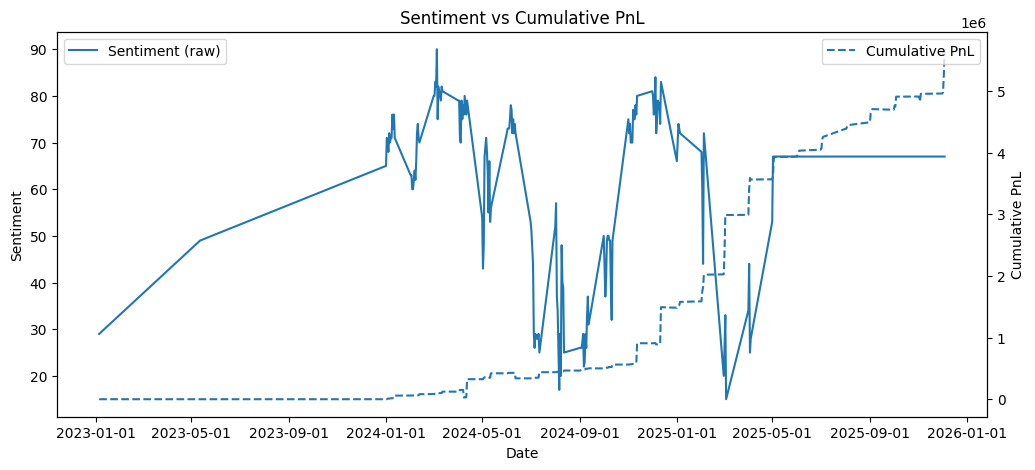

In [35]:
plt.figure(figsize=(12,5))
ax = plt.gca()
ax.plot(combined.index, combined['sentiment_raw'], label='Sentiment (raw)')
ax.set_ylabel('Sentiment')
ax.set_xlabel('Date')
ax2 = ax.twinx()
ax2.plot(combined.index, combined['cum_pnl'], label='Cumulative PnL', linestyle='--')
ax2.set_ylabel('Cumulative PnL')
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.title('Sentiment vs Cumulative PnL')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.show()

In [45]:
metrices = ['total_pnl', 'trades_count', 'total_vol', 'avg_lev', 'rolling_vol_14']
corrs = {m: combined['sentiment_raw'].corr(combined[m]) for m in metrices if m in combined.columns}
print("\nSimple Correlations (sentiment_raw vs metric):")
for k, v in corrs.items():
    print(f"{k}: {v:4f}")
feat_cols = ['total_pnl', 'trades_count', 'total_vol', 'rolling_vol_14']
feat_df = combined[feat_cols].dropna()
combined_aligned = combined.loc[feat_df.index].copy()
if not feat_df.empty and len(feat_df) >= 10:
    feat_std = (feat_df - feat_df.mean()) / feat_df.std()
    pca = PCA(n_components=min(4, feat_std.shape[1]))
    pca.fit(feat_std.fillna(0))
    print("\nPCA explained variance ratio:", pca.explained_variance_ratio_)
else:
    print("Skipping PCA: not enough data.")
if not feat_df.empty and len(feat_df) >= 10:
    k = 3
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    regimes = km.fit_predict(feat_std.fillna(0))
    print("\nKMeans regime counts:", np.bincount(regimes))
gc_df = combined[['sentiment_raw', 'total_pnl']].dropna()
if len(gc_df) > 30:
    res_sp = grangercausalitytests(gc_df[['total_pnl', 'sentiment_raw']], maxlag=7, verbose=False)
    print("\nGranger causality p-values (sentiment->pnl):", {lag: res_sp[lag][0]['ssr_ftest'][1] for lag in res_sp.keys()})
else:
    print("\nNot enough data for Granger causality test.")


Simple Correlations (sentiment_raw vs metric):
total_pnl: -0.022134
trades_count: -0.013851
total_vol: -0.000070
avg_lev:  nan
rolling_vol_14: -0.008848

PCA explained variance ratio: [0.64581948 0.17678502 0.12790227 0.04949323]

KMeans regime counts: [133  14  28]

Granger causality p-values (sentiment->pnl): {np.int64(1): np.float64(0.2945390725978395), np.int64(2): np.float64(0.29280187815953723), np.int64(3): np.float64(0.23526305886925475), np.int64(4): np.float64(0.07524879519916035), np.int64(5): np.float64(0.0780548521388704), np.int64(6): np.float64(0.02322965652022337), np.int64(7): np.float64(0.018907803973556483)}


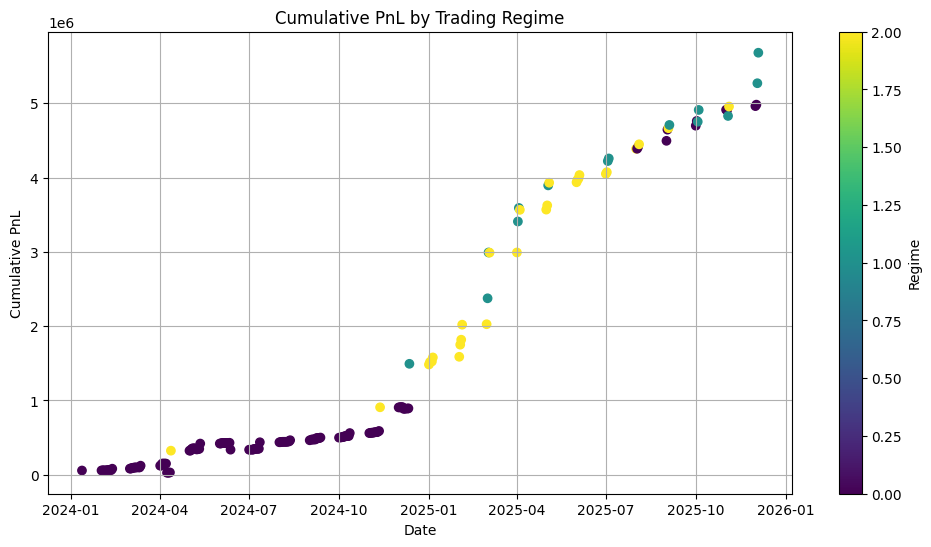

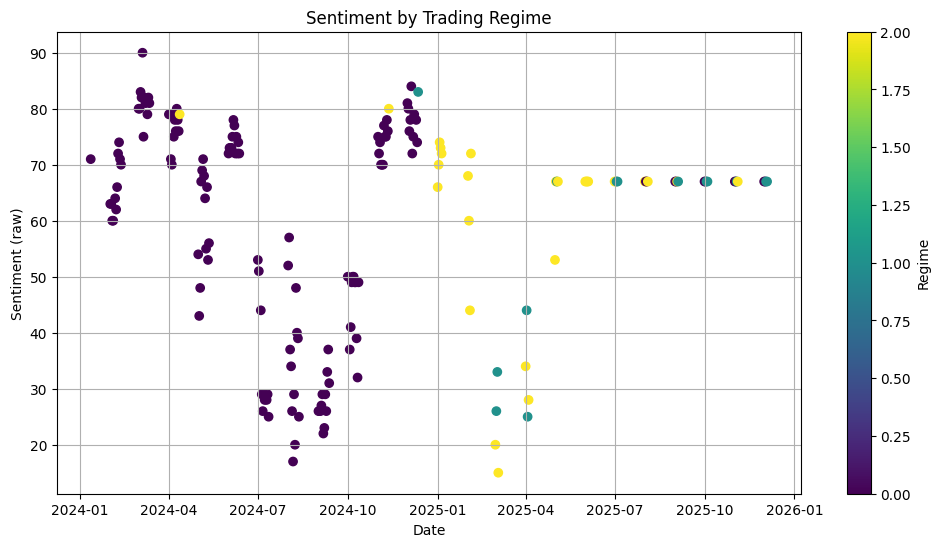

In [44]:
if 'regimes' in locals():
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(combined_aligned.index, combined_aligned['cum_pnl'], c=regimes, cmap='viridis', label='Cumulative PnL by Regime')
    plt.title('Cumulative PnL by Trading Regime')
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.colorbar(scatter, label='Regime')
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(combined_aligned.index, combined_aligned['sentiment_raw'], c=regimes, cmap='viridis', label='Sentiment by Regime')
    plt.title('Sentiment by Trading Regime')
    plt.xlabel('Date')
    plt.ylabel('Sentiment (raw)')
    plt.colorbar(scatter, label='Regime')
    plt.grid(True)
    plt.show()
else:
    print("KMeans regimes not available. Please run the KMeans clustering step first.")